# Runtime Analysis
This notebook is designed to compare output two or more ACCESS-OM2 simulations. 

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
client = Client()
client

Client Scheduler: tcp://127.0.0.1:36703 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 8 Memory: 34.36 GB


In [3]:
session = cc.database.create_session('/g/data/ik11/databases/ryf9091.db')

In [4]:
exptdict = OrderedDict([
    ('01deg_RYF9091',   {'expt':'01deg_jra55v13_ryf9091','dir':'access-om2-01'}),
    ('025deg_RYF9091',  {'expt':'025deg_jra55_ryf9091_gadi','dir':'access-om2-025'}),
    ('1deg_RYF9091',  {'expt':'1deg_jra55_ryf9091_gadi','dir':'access-om2'})
                        ])

In [4]:
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    dir = exptdict[ekey]['dir']
    cc.database.build_index('/g/data/ik11/outputs/'+dir+'/'+expt,session,update=True)

Indexing experiment: 01deg_jra55v13_ryf9091


100%|██████████| 10782/10782 [36:56<00:00,  4.87it/s] 


Indexing experiment: 025deg_jra55_ryf9091_gadi


100%|██████████| 8862/8862 [39:18<00:00,  3.76it/s]  


Indexing experiment: 1deg_jra55_ryf9091_gadi


100%|██████████| 6865/6865 [27:27<00:00,  4.17it/s]


## Just checking the final data for each expt.

In [35]:
for ekey in exptdict.keys():
    variable = 'temp_global_ave'
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session)
    start_year = np.int(np.ceil(cftime.date2num(var['time'].min(),'days since 0001-01-01','noleap')/365))
    end_year = np.int(np.ceil(cftime.date2num(var['time'].max(),'days since 0001-01-01','noleap')/365))
    print(expt+' goes from %d to %d'% (start_year, end_year))

01deg_jra55v13_ryf9091 goes from 1900 to 2099
025deg_jra55_ryf9091_gadi goes from 1900 to 2499
1deg_jra55_ryf9091_gadi goes from 1900 to 2419


## Scalar diagnostics

In [36]:
def plot_timeseries(variable):
    plt.figure(figsize=(10,5))
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        var = cc.querying.getvar(expt,variable,session)
        var.resample(time='Y').mean().plot(label=ekey)
    plt.title(variable)
    plt.legend()
    return

### Global Average Temperature

CPU times: user 1min 2s, sys: 3.1 s, total: 1min 5s
Wall time: 1min 35s


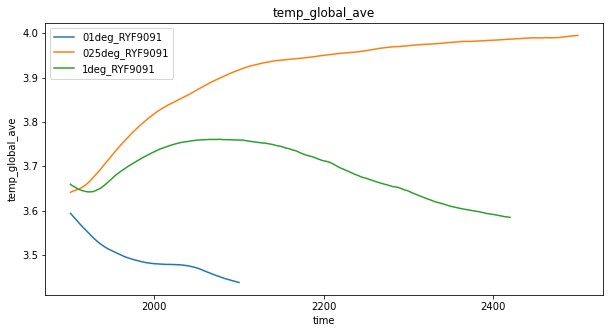

In [37]:
%%time
plot_timeseries('temp_global_ave')

### Global Average Salinity

CPU times: user 1min, sys: 2.53 s, total: 1min 2s
Wall time: 1min 34s


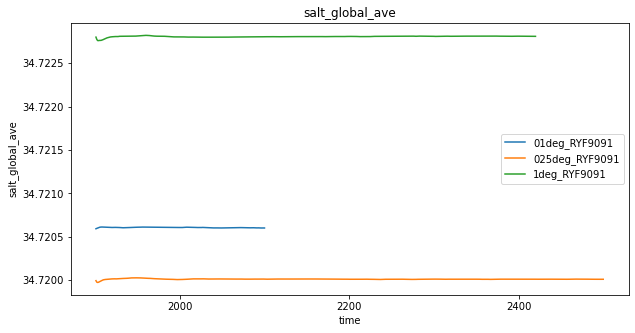

In [38]:
%%time
plot_timeseries('salt_global_ave')

### Surface Temperature

CPU times: user 1min, sys: 3.39 s, total: 1min 3s
Wall time: 1min 33s


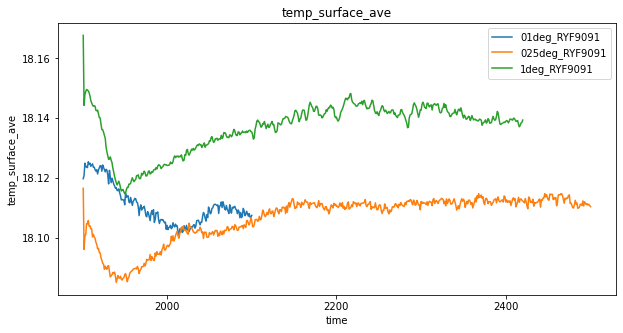

In [39]:
%%time
plot_timeseries('temp_surface_ave')

### Surface Salinity

CPU times: user 1min 1s, sys: 3.36 s, total: 1min 4s
Wall time: 1min 36s


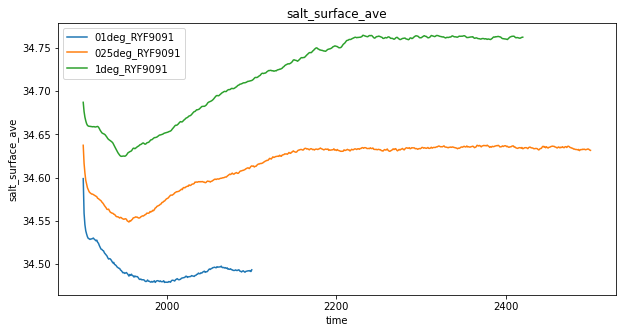

In [40]:
%%time
plot_timeseries('salt_surface_ave')

### Total Kinetic Energy

CPU times: user 59 s, sys: 2.71 s, total: 1min 1s
Wall time: 1min 32s


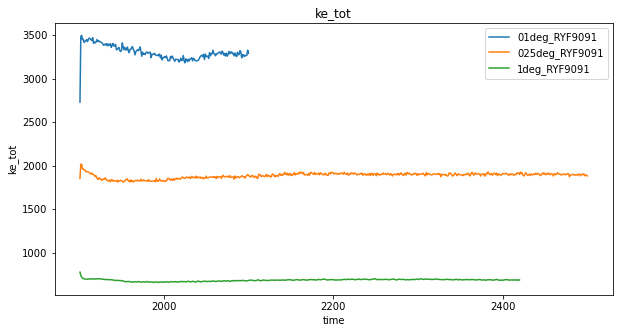

In [41]:
%%time
plot_timeseries('ke_tot')

## Area-Averaged Tracer Diagnostics

In [11]:
def plot_upper_ocean(variable):
    plt.figure(figsize=(10,5))
    zlevel = 1000
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        print(expt)
        var = cc.querying.getvar(expt,variable,session,ncfile='ocean.nc')
        varmean = var.sel(st_ocean = slice(0,zlevel)).mean('st_ocean').mean('yt_ocean').mean('xt_ocean').resample(time='Y').mean()
        varmean.plot(label=ekey)
    plt.legend()
    plt.title('Upper Ocean (< '+str(zlevel)+') '+variable)

### Upper Ocean Temperature/Salinity

In [ ]:
%%time
plot_upper_ocean('temp')

01deg_jra55v13_ryf9091


In [ ]:
%%time
plot_upper_ocean('salt')

### Deep Ocean Temperature/Salinity

In [5]:
def plot_lower_ocean(variable):
    plt.figure(figsize=(10,5))
    zlevel = 3000
    for ekey in exptdict.keys():
        expt = exptdict[ekey]['expt']
        print(expt)
        var = cc.querying.getvar(expt,variable,session,ncfile='ocean.nc')
        varmean = var.sel(st_ocean = slice(zlevel,None)).mean('st_ocean').mean('yt_ocean').mean('xt_ocean').resample(time='Y').mean()
        varmean.plot(label=ekey)
    plt.legend()
    plt.title('Deep Ocean (> '+str(zlevel)+') '+variable)
    

01deg_jra55v13_ryf9091
025deg_jra55_ryf9091_gadi
1deg_jra55_ryf9091_gadi
CPU times: user 29min 17s, sys: 1min 45s, total: 31min 3s
Wall time: 41min 15s


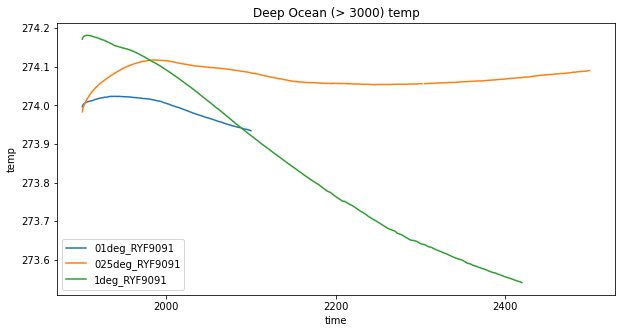

In [6]:
%%time
plot_lower_ocean('temp')

01deg_jra55v13_ryf9091
025deg_jra55_ryf9091_gadi
1deg_jra55_ryf9091_gadi
CPU times: user 29min 51s, sys: 1min 34s, total: 31min 26s
Wall time: 41min 39s


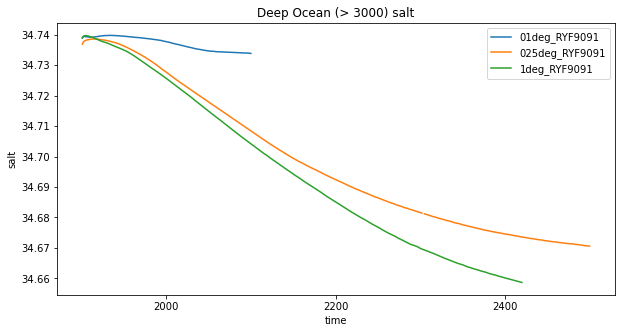

In [7]:
%%time
plot_lower_ocean('salt')

## Circulation Diagnostics

### Drake Passage Transport

01deg_jra55v13_ryf9091
025deg_jra55_ryf9091_gadi
1deg_jra55_ryf9091_gadi
CPU times: user 3min 18s, sys: 9.76 s, total: 3min 28s
Wall time: 6min 19s


Text(0.5, 1.0, 'ACC Transport')

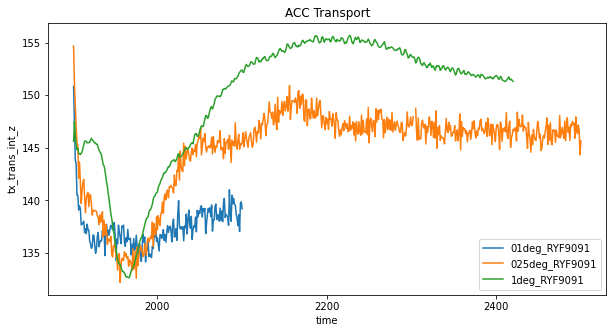

In [42]:
%%time

xmin=-69.9
ymin=-71.6
ymax=-51.0

variable='tx_trans_int_z'
plt.figure(figsize=(10,5))
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session)
    DP = var.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean').resample(time='Y').mean()/1e6/1036
    DP.plot(label=ekey)

plt.legend()
plt.title("ACC Transport")

### AABW overturning circulation @ 55°S

**To Do** - add GM to this.

01deg_jra55v13_ryf9091
025deg_jra55_ryf9091_gadi
1deg_jra55_ryf9091_gadi
CPU times: user 1h 14min 51s, sys: 2min 11s, total: 1h 17min 2s
Wall time: 1h 26min 7s


Text(0.5, 1.0, 'AABW Cell')

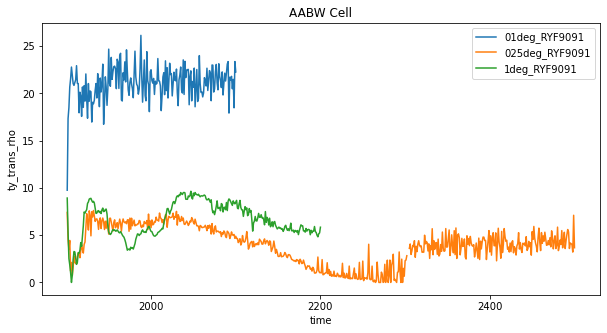

In [43]:
%%time
latitude=-55
plt.figure(figsize=(10,5))
variable='ty_trans_rho'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session)
    psi_aabw = var.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=latitude)*1.0e-9
    psi_aabw_sum = psi_aabw.cumsum('potrho') - psi_aabw.sum('potrho')
    psi_aabw_sum = -psi_aabw_sum.sel(potrho=slice(1036.2,None)).min('potrho').resample(time='Y').mean()
    psi_aabw_sum.plot(label=ekey)
plt.legend()
plt.title('AABW Cell')

### AMOC Overturning @ 26°N

01deg_jra55v13_ryf9091
025deg_jra55_ryf9091_gadi
1deg_jra55_ryf9091_gadi
CPU times: user 32min 29s, sys: 1min 15s, total: 33min 45s
Wall time: 42min 13s


Text(0.5, 1.0, 'AMOC Cell')

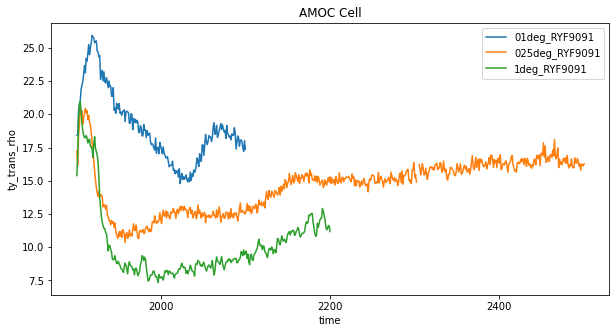

In [44]:
%%time
plt.figure(figsize=(10,5))
variable='ty_trans_rho'
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    print(expt)
    var = cc.querying.getvar(expt,variable,session)
    psi_amoc = var.sel(grid_xt_ocean=slice(-103,-5)).sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_amoc_sum = psi_amoc.cumsum('potrho') - psi_amoc.sum('potrho')
    psi_amoc_sum = psi_amoc_sum.sel(potrho=slice(1035.5,None)).max('potrho').resample(time='Y').mean()
    psi_amoc_sum.plot(label=ekey)
plt.legend()
plt.title('AMOC Cell')

In [5]:
def plot_psi(psi_avg, clev=np.arange(-25,25,2)):
    plt.figure(figsize=(12,8))
    p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=cm.cm.delta,levels=clev,extend='both')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

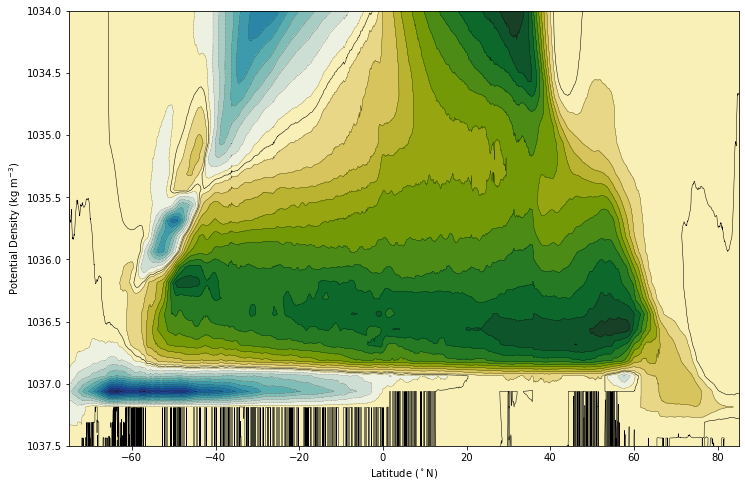

In [6]:
psi = cc.querying.getvar('01deg_jra55v13_ryf9091','ty_trans_rho',session,start_time='2090-01-01', end_time='2100-01-01')
psi = psi.mean('time').sum('grid_xt_ocean')*1.0e-9
psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
plot_psi(psi_avg)

### Ice Area (in both hemispheres)

AttributeError: 'Figure' object has no attribute 'plot'

<Figure size 720x648 with 0 Axes>

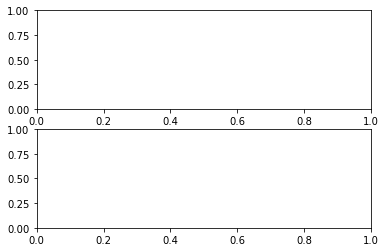

In [21]:
variable='aice_m'
plt.figure(figsize=(10,9))
ax = plt.subplots(2,1)
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    area = var*area_t
    area_zonalsum = area.sum('xt_ocean')
    NH_area = area_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').load()
    NH_area.plot(ax=ax[0],label=ekey)
    SH_area = area_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').load()
    SH_area.plot(ax=ax[1],label=ekey)
plt.legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')

### Ice volume (in both hemispheres)

In [ ]:
variable='vicen_m'
plt.figure(figsize=(10,9))
ax = plt.subplots(2,1)
for ekey in exptdict.keys():
    expt = exptdict[ekey]['expt']
    var = cc.querying.getvar(expt,variable,session,coords="all")
    area_t = cc.querying.getvar(expt, 'area_t',session,n=1)
    var.coords['ni'] = area_t['xt_ocean'].values
    var.coords['nj'] = area_t['yt_ocean'].values
    var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))
    vol = var*area_t
    vol_zonalsum = vol.sum('xt_ocean').sum('nc')
    NH_vol = vol_zonalsum.sel(yt_ocean=slice(45, 90)).sum('yt_ocean').load()
    NH_vol.plot(ax=ax[0],label=ekey)
    SH_vol = vol_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').load()
    SH_vol.plot(ax=ax[1],label=ekey)
plt.legend()
ax[0].set_title('Arctic')
ax[1].set_title('Southern Ocean')

In [22]:
variable='aice_m'
expt = exptdict['01deg_RYF9091']['expt']
var = cc.querying.getvar(expt,variable,session,decode_coords=False)

In [23]:
var

,Array,Chunk
Bytes,93.31 GB,2.43 MB
Shape,"(2400, 2700, 3600)","(1, 675, 900)"
Count,79200 Tasks,38400 Chunks
Type,float32,numpy.ndarray


In [24]:
area_t = cc.querying.getvar(expt, 'area_t',session,n=1)

In [25]:
var.coords['ni'] = area_t['xt_ocean'].values
var.coords['nj'] = area_t['yt_ocean'].values
var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

In [ ]:
area = var*area_t
area_zonalsum = area.sum('xt_ocean')
SH_area = area_zonalsum.sel(yt_ocean=slice(-90, -45)).sum('yt_ocean').resample(time='Y').mean().load()
SH_area.plot()